# Setup

In [99]:
import pandas as pd
import datetime
from wordcloud import WordCloud, STOPWORDS 
import sys
import os
import numpy as np
from PIL import Image
from textblob import TextBlob
import nltk
import re
import matplotlib
import matplotlib.pyplot as plt
import gensim
import nltk
from nltk.tokenize import word_tokenize
import pprint
import sklearn.feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# Import Data

In [2]:
df = pd.read_csv("sms_scan_exit_survey.csv",keep_default_na=False) #leave blanks as blanks

###  dates take the place of subject labels
### Phrasing of question was changed after first six participants, much messier individual sequence responses for those first subjects, so I can either spend a bunch of time trying to organize that, or ignore those subjects, or just ignore individual sequences and merge across questions

In [4]:
# rename columns
df.columns = ['Subject','Q1','Q2','Q3','Q4','Q5','Q6','Q7']
# merge across questions, so all responses from each subject will be in one column
df['merged'] =  df.iloc[:, 1:].sum(axis=1)

# Cleanup Data

In [91]:
# make everything lowercase
df['lowered'] = df.merged.apply(str.lower)
# now remove condition labels for merged condition approach
df['cleaned'] = {x.replace('intact', '').replace('scrambled', '').replace('random','') for x in df['lowered']}
# df['merged']= re.sub('[ES]', 'a', df['merged'])
# remove anything that's not a letter
# drop_this = re.compile(['^a-zA-Z '])
# df['cleaned'] = [drop_this.sub('',x) for x in df['cleaned']]
# df['lowered'] = df.merged.apply(str.lower)
drop_this = re.compile('[^a-z ]', re.MULTILINE)
df['cleaned'] = {drop_this.sub(' ', x) for x in df['cleaned']}

In [90]:
# df.tail()
# print(df['merged'][23])
# df['cleaned'][2]

'       used a singular event to remember this sequence  scene from tv show    reasons why   each time this sequence of words appeared  i visualized the tv show s scene          for this sequence  i remembered that the two  m  words came first and then the short  s  word and that research was last  i did not use a singular event or a mix of events to remember this sequence           this was  so i did not memorize the sequence  however  all the words in this sequence were related to the military so anytime  i saw one of the words in this sequence i knew the rest would be ized          for this sequence  the first two words rhyme and then the next two words start with  m  and  propose  is the last word   that s how i remember this sequence  i thought of many similar events where couples date and get married when remembering this sequence         i understood this sequence to be related to the singular event of my mom gardening and as it happened in order  it was easy to remember        

# Look for between subject overall differences by building a tf-idf model from all subjects

In [5]:
# tokenize merged responses
df['tok_merged'] = [[w.lower() for w in word_tokenize(text)] 
            for text in df['merged']]

Mean # of tokens: 18467


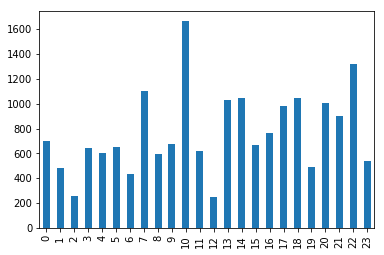

In [6]:
# plot number of tokens by subject
num_toks = df.tok_merged.apply(len)
print('Mean # of tokens:' ,np.sum(num_toks))
num_toks.plot(kind = 'bar')
plt.show()

In [7]:
# create dictionary
dictionary = gensim.corpora.Dictionary(df['tok_merged'])
# see how many words in the dictionary
len(dictionary)
# I would have thought there would be more unique words... I guess that's good? 

1847

In [8]:
# create a corpus 
corpus = [dictionary.doc2bow(x) for x in df['tok_merged']]
# creat tf-idf model of the corpus
tf_idf = gensim.models.TfidfModel(corpus)
print(tf_idf)

TfidfModel(num_docs=24, num_nnz=6034)


In [9]:
# creat similarlity object with gensim
# get path
cwd = os.getcwd()
sims = gensim.similarities.Similarity(cwd,tf_idf[corpus],
                                      num_features=len(dictionary))
print(sims)

Similarity index with 24 documents in 0 shards (stored under /Users/WBR/walter/python_psc290/hw)


In [10]:
# now create a query from one sub's responses by first bag of words-ing
query_doc_bow = dictionary.doc2bow(df['tok_merged'][1])
# then index tf_idf weights
query_doc_tf_idf = tf_idf[query_doc_bow]

In [11]:
sims[query_doc_tf_idf]

array([0.04068984, 1.0000002 , 0.15550756, 0.02335448, 0.11137828,
       0.05439073, 0.06243492, 0.05343318, 0.16747609, 0.14928679,
       0.06551225, 0.03037687, 0.00508134, 0.04148054, 0.05474997,
       0.0772889 , 0.02482655, 0.02682976, 0.034339  , 0.02597768,
       0.06060001, 0.02821321, 0.03432068, 0.05014485], dtype=float32)

In [12]:
sims.similarity_by_id

<bound method Similarity.similarity_by_id of <gensim.similarities.docsim.Similarity object at 0x1a1dcd6550>>

In [13]:
list(sims)[0]

array([0.999999  , 0.04068984, 0.0532045 , 0.0438494 , 0.1888521 ,
       0.07426773, 0.09896921, 0.13354322, 0.0614248 , 0.07154027,
       0.15344808, 0.12431833, 0.07758443, 0.251034  , 0.06363554,
       0.1644273 , 0.04082078, 0.07279146, 0.04689367, 0.0554514 ,
       0.11407172, 0.08240511, 0.08692756, 0.0948897 ], dtype=float32)

In [95]:
vect = TfidfVectorizer(min_df=1, stop_words= 'english')
tfidf = vect.fit_transform(df['cleaned'])
pairwise_similarity = tfidf * tfidf.T

In [96]:
dense_pairsim = pairwise_similarity.todense()

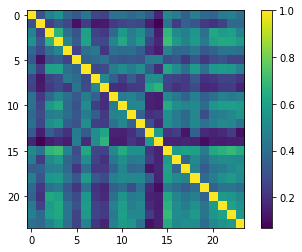

In [94]:
plt.imshow(dense_pairsim)
plt.colorbar()
plt.show()

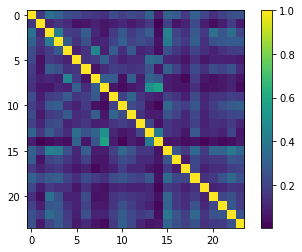

In [97]:
# with stopwords removed
plt.imshow(dense_pairsim)
plt.colorbar()
plt.show()


In [100]:
# gimme two clusters
true_k = 2
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(tfidf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=2, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [104]:
# source https://stackoverflow.com/questions/27889873/clustering-text-documents-using-scikit-learn-kmeans-in-python
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vect.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i,)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print()

Top terms per cluster:
Cluster 0:
 imagined
 memorized
 came
 knew
 ball
 just
 tea
 clean
 harder
 logical

Cluster 1:
 sequence
 thought
 order
 yes
 words
 remember
 scramble
 event
 events
 just



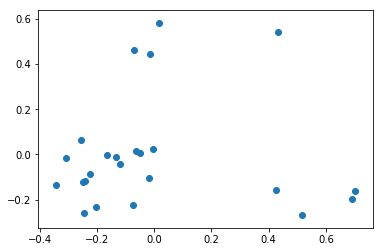

In [106]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# newsgroups_train = fetch_20newsgroups(subset='train', 
#                                       categories=['alt.atheism', 'sci.space'])
# pipeline = Pipeline([
#     ('vect', CountVectorizer()),
#     ('tfidf', TfidfTransformer()),
# ])        
# X = pipeline.fit_transform(newsgroups_train.data).todense()

X = tfidf.todense()

pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)
plt.scatter(data2D[:,0], data2D[:,1], c= data2D.) # c=data.target
plt.show()

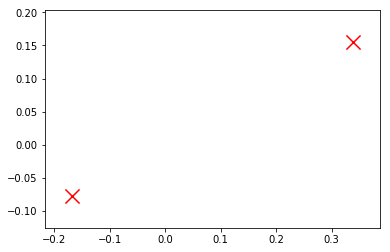

In [108]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2).fit(X)
centers2D = pca.transform(kmeans.cluster_centers_)

# plt.hold(True)
plt.scatter(centers2D[:,0], centers2D[:,1], 
            marker='x', s=200, linewidths=3, c='r')
plt.show() 